# Stock Price Predictor

I created a LSTM (Long Short Term Memory) model that predicts the next day closing price of stocks. For the data, I used the Yahoo! Finance's API to get Apple's stock market data from the last 20 years.

In [1]:
import yfinance as yf
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Dropout
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [2]:
data = yf.Ticker("AAPL")
data = data.history(period="max")
data = data.loc["2004-01-01":].copy()
data = data.loc[:, data.columns.intersection(['Close'])]
data

,Close
Date,
2004-01-02 00:00:00-05:00,0.320901
2004-01-05 00:00:00-05:00,0.334322
2004-01-06 00:00:00-05:00,0.333115
2004-01-07 00:00:00-05:00,0.340655
2004-01-08 00:00:00-05:00,0.352267
...,...
2024-10-23 00:00:00-04:00,230.759995
2024-10-24 00:00:00-04:00,230.570007
2024-10-25 00:00:00-04:00,231.410004


<Axes: xlabel='Date'>

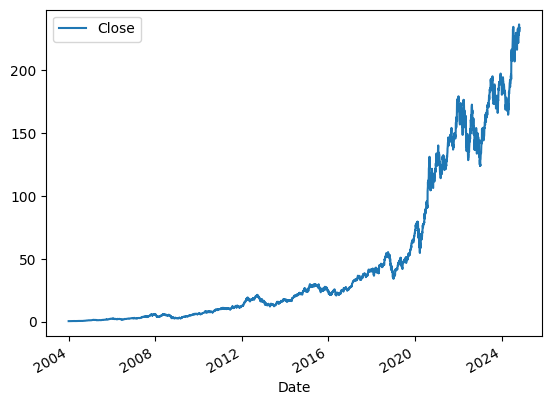

In [3]:
data.plot.line(y="Close", use_index=True)

In [4]:
len(data)

5242

Creating the training and testing datasets and preprocessing the data

In [5]:
train_size = int(len(data) * 0.9)
train = data[["Close"]].iloc[:train_size]
test = data[["Close"]].iloc[train_size:]

In [6]:
scaler = MinMaxScaler()
scaler.fit(data)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
scaled_train

array([[0.00000000e+00],
       [5.68314647e-05],
       [5.17215381e-05],
       ...,
       [6.28646586e-01],
       [6.30070577e-01],
       [6.34216750e-01]])

The model is trained on a sequence of the first 59 days, which then is used to predict the price on the 60th day. The model is then trained on the next 59 days(2-60) and predicts the price on the 61st day. This process is repeated for all sequences in the datasets.

In [7]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

In [8]:
sequence_length = 60
X_train, y_train = create_sequences(scaled_train, sequence_length)
X_test, y_test = create_sequences(scaled_test, sequence_length)

batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

Creating and training the model

In [9]:
def build_model(sequence_length, n_features=1):
    model = Sequential([
        Input(shape=(sequence_length, n_features)),
        LSTM(300, activation='relu'),
        Dense(1, activation="linear")
    ])
    return model

In [10]:
model = build_model(sequence_length)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping( # used to prevent overfitting
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [12]:
model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)

Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 1.0610e-04 - mae: 0.0063 - val_loss: 0.0049 - val_mae: 0.0553
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0103 - mae: 0.0550 - val_loss: 0.0212 - val_mae: 0.1362
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0087 - mae: 0.0585 - val_loss: 0.0015 - val_mae: 0.0327
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0052 - mae: 0.0448 - val_loss: 8.6936e-04 - val_mae: 0.0234
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0053 - mae: 0.0446 - val_loss: 5.6994e-04 - val_mae: 0.0191
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0039 - mae: 0.0398 - val_loss: 5.6257e-04 - val_mae: 0.0192
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0024 - mae: 0.0313 - val_loss: 4.4609e-04 - val_mae: 0.0165
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0016 - mae: 0.0281 - val_loss: 5.0696e-04 - val_mae: 0.0175
Epoch 9/50
146/146 ━━━━━

Using the model to predict the prices in the testing dataset and then displaying the relevant results and statistics

In [13]:
def get_predictions():
    scaled_predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(scaled_predictions)
    unscaled_y_test = scaler.inverse_transform(y_test)
    return predictions, unscaled_y_test

In [14]:
predictions, unscaled_y_test = get_predictions()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [15]:
results = pd.DataFrame(unscaled_y_test, index=data.index[train_size+sequence_length:])
results = results.rename(columns={0: 'Actual'})
results['Predicted'] = predictions
results

,Actual,Predicted
Date,,
2022-12-22 00:00:00-05:00,130.997925,133.340408
2022-12-23 00:00:00-05:00,130.631363,133.030212
2022-12-27 00:00:00-05:00,128.818405,132.305023
2022-12-28 00:00:00-05:00,124.865585,130.875839
2022-12-29 00:00:00-05:00,128.402344,127.969063
...,...,...
2024-10-23 00:00:00-04:00,230.759995,234.962723
2024-10-24 00:00:00-04:00,230.570007,231.341385
2024-10-25 00:00:00-04:00,231.410004,228.364685


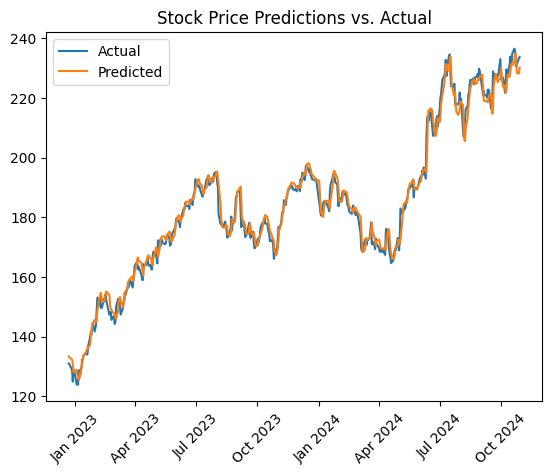

In [16]:
plt.plot(results['Actual'], label='Actual')
plt.plot(results['Predicted'], label='Predicted')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.title('Stock Price Predictions vs. Actual')
plt.legend()
plt.show()

In [17]:
rmse = sqrt(mean_squared_error(results['Actual'], results['Predicted']))
rmse

3.0107899619933898

In [18]:
mae = mean_absolute_error(results['Actual'], results['Predicted'])
mae

2.3005263625934558